In [1]:
#needed after restructuring of directory
import os
os.chdir('/Users/alexchandler/UFC_Prediction_2022')
os.getcwd()

'/Users/alexchandler/UFC_Prediction_2022'

In [2]:
#this is all copied from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image
import torch
import torchvision

from os.path import exists

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = models.vgg19(pretrained=True).features.to(device).eval()

style 0


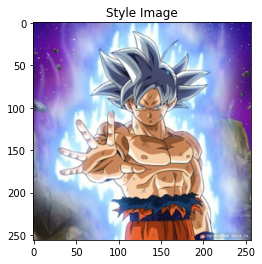

style 1


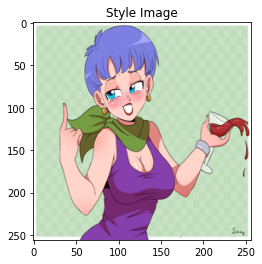

style 2


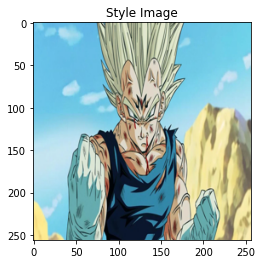

style 3


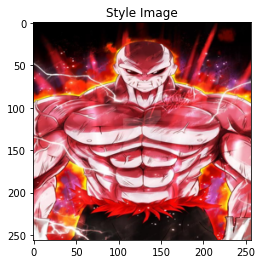

style 4


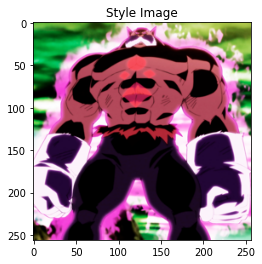

style 5


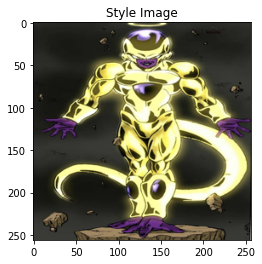

style 6


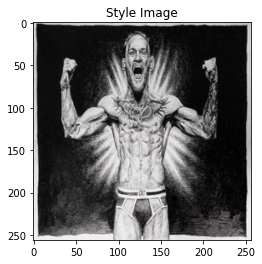

In [4]:

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image):
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

styleimage0=Image.open("src/models/buildingMLModel/images/escher1.jpeg") 

styleimage1=Image.open("src/models/buildingMLModel/images/onepunch.jpg")

styleimage2=Image.open("src/models/buildingMLModel/images/pixelart.jpeg")
styleimage3=Image.open("src/models/buildingMLModel/images/vegito.jpeg") 
styleimage4=Image.open("src/models/buildingMLModel/images/conorpainting.jpeg")  
styleimage5=Image.open("src/models/buildingMLModel/images/picasso.jpeg")  
styleimage6=Image.open("src/models/buildingMLModel/images/paintedoblivion.webp")
styleimage7=Image.open("src/models/buildingMLModel/images/starrynight.jpeg")
styleimage8=Image.open("src/models/buildingMLModel/images/bear.jpeg")
styleimage9=Image.open("src/models/buildingMLModel/images/god.jpeg")
styleimage10=Image.open("src/models/buildingMLModel/images/vangogh.jpeg")  

thresh={0:950,
       1: 250,
        2:1200,
        3: 800,
        4:250,
        5: 40,
        6: 60, 
        7: 100,
        8: 200,
        9: 150,
        10: 160,
       }


styleimage0=styleimage0.resize((256,256))
styleimage1=styleimage1.resize((256,256))
styleimage2=styleimage2.resize((256,256))
styleimage3=styleimage3.resize((256,256))
styleimage4=styleimage4.resize((256,256))
styleimage5=styleimage5.resize((256,256))
styleimage6=styleimage6.resize((256,256))
styleimage7=styleimage7.resize((256,256))
styleimage8=styleimage8.resize((256,256))
styleimage9=styleimage9.resize((256,256))
styleimage10=styleimage10.resize((256,256))



fighterimage=Image.open("src/models/buildingMLModel/images/2KhamzatChimaev.jpg")
fighterimage=fighterimage.resize((256,256))

style = [image_loader(styleimage0),image_loader(styleimage1),image_loader(styleimage2),
         image_loader(styleimage3), image_loader(styleimage4), image_loader(styleimage5), 
         image_loader(styleimage6), image_loader(styleimage7), image_loader(styleimage8),
        image_loader(styleimage9), image_loader(styleimage10)]

#defining an alternate line of styles
styleimage0alt=Image.open("src/models/buildingMLModel/images/uigoku.jpeg")  
styleimage1alt=Image.open("src/models/buildingMLModel/images/bulma.jpeg")
styleimage2alt=Image.open("src/models/buildingMLModel/images/vegeta.webp")
styleimage3alt=Image.open("src/models/buildingMLModel/images/jiren.jpeg")  
styleimage4alt=Image.open("src/models/buildingMLModel/images/top.webp")  
styleimage5alt=Image.open("src/models/buildingMLModel/images/frieza.jpeg")
styleimage6alt=Image.open("src/models/buildingMLModel/images/conor.jpeg")


threshalt={0: 500,
           1: 500,
           2: 1000,
           3: 525,
           4: 1000,
           5:400,
           6:150
       }

styleimage0alt=styleimage0alt.resize((256,256))
styleimage1alt=styleimage1alt.resize((256,256))
styleimage2alt=styleimage2alt.resize((256,256))
styleimage3alt=styleimage3alt.resize((256,256))
styleimage4alt=styleimage4alt.resize((256,256))
styleimage5alt=styleimage5alt.resize((256,256))
styleimage6alt=styleimage6alt.resize((256,256))


stylealt = [image_loader(styleimage0alt),image_loader(styleimage1alt),image_loader(styleimage2alt),
          image_loader(styleimage3alt), image_loader(styleimage4alt), 
         image_loader(styleimage5alt), image_loader(styleimage6alt)]

fighterimage=Image.open("src/models/buildingMLModel/images/2KhamzatChimaev.jpg")
fighterimage=fighterimage.resize((256,256))

content_img = image_loader(fighterimage)
assert all(style[i].size() == content_img.size() for i in range(len(style))), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] ==50:
                print('Style Loss : {:4f}'.format(style_score.item()))
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    return input_img

alt=False

def run_style_transfer_adaptive(cnn, normalization_mean, normalization_std,
                       content_img, styleindex, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    style_img=style[styleindex]
    if alt==True:
        style_img=stylealt[styleindex]
    firstLoss={0:0}
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    while run[0] <= num_steps and firstLoss[0]==0:
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                if (style_score.item()>thresh[styleindex] and alt==False) or (style_score.item()>threshalt[styleindex] and alt==True):
                    firstLoss[0]=style_score.item()
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)
    if firstLoss[0]==0:
        return input_img
    else:
        return 'empty'
    
    
# add the original input image to the figure:
plt.figure()

for i in range(len(stylealt)):
    print('style '+str(i))
    imshow(stylealt[i], title='Style Image')
    
    
    

In [3]:
ufcfighterscrap =pd.read_csv('src/models/buildingMLModel/data/processed/fighter_stats.csv',sep=',',low_memory=False)
names = list(ufcfighterscrap['name'])

In [ ]:
#testing stylization
fighterimage=Image.open("src/models/buildingMLModel/images/1NateDiaz.jpg")
fighterimage=fighterimage.resize((256,256))
content_img = image_loader(fighterimage)
styleindex=random.randint(1,len(style))-1
output = 'empty'
while output =='empty':
    input_img = content_img.clone()
    styleindex=(styleindex+1)%len(style)
    print('trying style number '+str((styleindex+1)%len(style)))
    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                       content_img, styleindex, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1)

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-7 done
#can run about 90 overnight
for name in names[8:100]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty' and k<=5:
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str((styleindex+1)%len(style)))
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
        except:
            continue

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-7 done
#can run about 90 overnight
for name in names[100:200]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty' and k<=5:
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str((styleindex+1)%len(style)))
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
        except:
            continue

In [4]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-200 done... testing next 30 to see if there are any running poorly
#can run about 90 overnight
for name in names[200:230]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print('couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                print('trying style number '+str(styleindex)+' for '+name)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print('saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

trying style number 2 for ChrisWeidman


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/241124489.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/241124489.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


saving: images2/1ChrisWeidman.jpg in style 2
trying style number 0 for ChrisWeidman
saving: images2/2ChrisWeidman.jpg in style 0
trying style number 4 for ChrisWeidman
trying style number 5 for ChrisWeidman
saving: images2/3ChrisWeidman.jpg in style 5
trying style number 5 for ChrisWeidman
saving: images2/4ChrisWeidman.jpg in style 5
trying style number 3 for OmariAkhmedov
trying style number 4 for OmariAkhmedov
saving: images2/1OmariAkhmedov.jpg in style 4
trying style number 1 for OmariAkhmedov
trying style number 2 for OmariAkhmedov
trying style number 3 for OmariAkhmedov
trying style number 4 for OmariAkhmedov
trying style number 5 for OmariAkhmedov
saving: images2/2OmariAkhmedov.jpg in style 5
trying style number 6 for OmariAkhmedov
saving: images2/3OmariAkhmedov.jpg in style 6
trying style number 6 for OmariAkhmedov
saving: images2/4OmariAkhmedov.jpg in style 6
trying style number 5 for DarrenStewart
saving: images2/1DarrenStewart.jpg in style 5
trying style number 5 for DarrenSt

saving: images2/3YoussefZalal.jpg in style 6
trying style number 6 for YoussefZalal
saving: images2/4YoussefZalal.jpg in style 6
trying style number 6 for PeterBarrett
saving: images2/1PeterBarrett.jpg in style 6
trying style number 3 for PeterBarrett
trying style number 4 for PeterBarrett
trying style number 5 for PeterBarrett
saving: images2/2PeterBarrett.jpg in style 5
trying style number 0 for PeterBarrett
trying style number 1 for PeterBarrett
trying style number 2 for PeterBarrett
trying style number 3 for PeterBarrett
saving: images2/3PeterBarrett.jpg in style 3
trying style number 4 for PeterBarrett
trying style number 5 for PeterBarrett
saving: images2/4PeterBarrett.jpg in style 5
trying style number 2 for IrwinRivera
saving: images2/1IrwinRivera.jpg in style 2
trying style number 1 for IrwinRivera
trying style number 2 for IrwinRivera
trying style number 3 for IrwinRivera
trying style number 4 for IrwinRivera
trying style number 5 for IrwinRivera
saving: images2/2IrwinRivera.

In [11]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-200 done... testing next 30 to see if there are any running poorly
#can run about 90 overnight
for name in names[230:250]:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print(str(j)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


1 saving: images2/1JonathanMartinez.jpg in style 5
2 saving: images2/2JonathanMartinez.jpg in style 5
3 saving: images2/3JonathanMartinez.jpg in style 5
4 saving: images2/4JonathanMartinez.jpg in style 7
1 saving: images2/1FrankieSaenz.jpg in style 4
2 saving: images2/2FrankieSaenz.jpg in style 7
3 saving: images2/3FrankieSaenz.jpg in style 3
4 saving: images2/4FrankieSaenz.jpg in style 3
1 saving: images2/1NateManess.jpg in style 1
2 saving: images2/2NateManess.jpg in style 0
3 saving: images2/3NateManess.jpg in style 1
4 saving: images2/4NateManess.jpg in style 7
1 saving: images2/1JohnnyMunoz.jpg in style 6
2 saving: images2/2JohnnyMunoz.jpg in style 1
3 saving: images2/3JohnnyMunoz.jpg in style 5
4 saving: images2/4JohnnyMunoz.jpg in style 7
1 saving: images2/1JamallEmmers.jpg in style 3
2 saving: images2/2JamallEmmers.jpg in style 2
3 saving: images2/3JamallEmmers.jpg in style 2
4 saving: images2/4JamallEmmers.jpg in style 3
1 saving: images2/1VinceCachero.jpg in style 5
2 saving:

In [ ]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
img1 = output
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img1, 'img1.png')

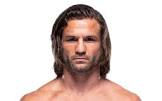

In [8]:
fighterimage=Image.open("src/models/buildingMLModel/images/3AlexanderMunoz.jpg");fighterimage

Building the style transfer model..


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 48.677467 Content Loss: 24.331326
run [100]:
Style Loss : 12.180967 Content Loss: 22.458076
run [150]:
Style Loss : 5.507638 Content Loss: 20.124273
run [200]:
Style Loss : 3.353812 Content Loss: 18.208982
run [250]:
Style Loss : 2.498357 Content Loss: 16.713793
run [300]:
Style Loss : 1.956803 Content Loss: 15.549734


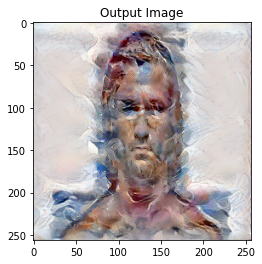

In [9]:
#to test the most recently added style image
fighterimage=fighterimage.resize((256,256))
content_img = image_loader(fighterimage)
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style[-1], input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [10]:
img1 = output
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img1, "src/models/buildingMLModel/images2/3AlexanderMunoz.jpg")

In [16]:
[1,2,3,4,5,6,7,8,9,0][9:3:-1]

[0, 9, 8, 7, 6, 5]

In [ ]:
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#0-200 done... testing next 30 to see if there are any running poorly
#can run about 90 overnight
i=len(names)
for name in names[len(names):2054:-1]:
    i-=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_21743/3183849233.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


2240 saving: images2/1TeilaTuli.jpg in style 7
2240 saving: images2/2TeilaTuli.jpg in style 1
2240 saving: images2/3TeilaTuli.jpg in style 2
2240 saving: images2/4TeilaTuli.jpg in style 1
2239 saving: images2/1ArtJimmerson.jpg in style 4
2239 saving: images2/2ArtJimmerson.jpg in style 7
2239 saving: images2/3ArtJimmerson.jpg in style 3
2239 saving: images2/4ArtJimmerson.jpg in style 5
2238 saving: images2/1KevinRosier.jpg in style 7
2238 saving: images2/2KevinRosier.jpg in style 5
2238 saving: images2/3KevinRosier.jpg in style 0
2238 saving: images2/4KevinRosier.jpg in style 6
2237 saving: images2/1TrentJenkins.jpg in style 7
2237 saving: images2/2TrentJenkins.jpg in style 1
2237 saving: images2/3TrentJenkins.jpg in style 6
2237 saving: images2/4TrentJenkins.jpg in style 1
2236 saving: images2/1GerardGordeau.jpg in style 7
2236 saving: images2/2GerardGordeau.jpg in style 2
2236 saving: images2/3GerardGordeau.jpg in style 3
2236 saving: images2/4GerardGordeau.jpg in style 6
2235 saving:

2198 saving: images2/2RemcoPardoel.jpg in style 6
2198 saving: images2/3RemcoPardoel.jpg in style 5
2198 saving: images2/4RemcoPardoel.jpg in style 7
2197 saving: images2/1SteveJennum.jpg in style 3
2197 saving: images2/2SteveJennum.jpg in style 3
2197 saving: images2/3SteveJennum.jpg in style 3
2197 saving: images2/4SteveJennum.jpg in style 7
2196 saving: images2/1KeithHackney.jpg in style 4
2196 saving: images2/2KeithHackney.jpg in style 3
2196 saving: images2/3KeithHackney.jpg in style 5
2196 saving: images2/4KeithHackney.jpg in style 5
2195 saving: images2/1OlegTaktarov.jpg in style 6
2195 saving: images2/2OlegTaktarov.jpg in style 5
2195 saving: images2/3OlegTaktarov.jpg in style 1
2195 saving: images2/4OlegTaktarov.jpg in style 5
2194 saving: images2/1ThomasRamirez.jpg in style 5
2194 saving: images2/2ThomasRamirez.jpg in style 5
2194 saving: images2/3ThomasRamirez.jpg in style 5
2194 saving: images2/4ThomasRamirez.jpg in style 3
2193 saving: images2/1PaulHerrera.jpg in style 6
2

2157 saving: images2/4YuriVaulin.jpg in style 7
2156 saving: images2/1JoeMoreira.jpg in style 5
2156 saving: images2/2JoeMoreira.jpg in style 5
2156 saving: images2/3JoeMoreira.jpg in style 4
2156 saving: images2/4JoeMoreira.jpg in style 7
2155 saving: images2/1ToddButler.jpg in style 7
2155 saving: images2/2ToddButler.jpg in style 5
2155 saving: images2/3ToddButler.jpg in style 5
2155 saving: images2/4ToddButler.jpg in style 3
2154 saving: images2/1MotiHorenstein.jpg in style 3
2154 saving: images2/2MotiHorenstein.jpg in style 6
2154 saving: images2/3MotiHorenstein.jpg in style 7
2154 saving: images2/4MotiHorenstein.jpg in style 7
2153 saving: images2/1BrianJohnston.jpg in style 5
2153 saving: images2/2BrianJohnston.jpg in style 3
2153 saving: images2/3BrianJohnston.jpg in style 1
2153 saving: images2/4BrianJohnston.jpg in style 6
2152 saving: images2/1DanBobish.jpg in style 3
2152 saving: images2/2DanBobish.jpg in style 5
2152 saving: images2/3DanBobish.jpg in style 7
2152 saving: im

2115 saving: images2/2TonyPetarra.jpg in style 6
2115 saving: images2/3TonyPetarra.jpg in style 5
2115 saving: images2/4TonyPetarra.jpg in style 0
2114 saving: images2/1BasRutten.jpg in style 7
2114 saving: images2/2BasRutten.jpg in style 1
2114 saving: images2/3BasRutten.jpg in style 1
2114 saving: images2/4BasRutten.jpg in style 4
2113 saving: images2/1TravisFulton.jpg in style 0
2113 saving: images2/2TravisFulton.jpg in style 5
2113 saving: images2/3TravisFulton.jpg in style 0
2113 saving: images2/4TravisFulton.jpg in style 4
2112 saving: images2/1AndreRoberts.jpg in style 7
2112 saving: images2/2AndreRoberts.jpg in style 7
2112 saving: images2/3AndreRoberts.jpg in style 5
2112 saving: images2/4AndreRoberts.jpg in style 6
2111 saving: images2/1RoyceAlger.jpg in style 5
2111 saving: images2/2RoyceAlger.jpg in style 7
2111 saving: images2/3RoyceAlger.jpg in style 4
2111 saving: images2/4RoyceAlger.jpg in style 1
2110 saving: images2/1FlavioLuizMoura.jpg in style 7
2110 saving: images2

2074 saving: images2/3LaverneClark.jpg in style 0
2074 saving: images2/4LaverneClark.jpg in style 3
2073 saving: images2/1DanSevern.jpg in style 6
2073 saving: images2/2DanSevern.jpg in style 5
2073 saving: images2/3DanSevern.jpg in style 7
2073 saving: images2/4DanSevern.jpg in style 2
2072 saving: images2/1BenEarwood.jpg in style 5
2072 saving: images2/2BenEarwood.jpg in style 5
2072 saving: images2/3BenEarwood.jpg in style 3
2072 saving: images2/4BenEarwood.jpg in style 3
2071 saving: images2/1AlexStiebling.jpg in style 1
2071 saving: images2/2AlexStiebling.jpg in style 7
2071 saving: images2/3AlexStiebling.jpg in style 6
2071 saving: images2/4AlexStiebling.jpg in style 3
2070 saving: images2/1MarkHughes.jpg in style 1
2070 saving: images2/2MarkHughes.jpg in style 5
2070 saving: images2/3MarkHughes.jpg in style 0
2070 saving: images2/4MarkHughes.jpg in style 4
2069 saving: images2/1JohnLewis.jpg in style 6
2069 saving: images2/2JohnLewis.jpg in style 5
2069 saving: images2/3JohnLewi

In [ ]:
#lowered the threshold from 170 to 150 lets see if we get any failures
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#[0:250] and [len(names):2054:-1] done... 
#can run about 90 overnight
i=len(names)
for name in names[2054:1800:-1]:
    i-=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_34184/1865165917.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_34184/1865165917.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


2240 saving: images2/1HomerMoore.jpg in style 1
2240 saving: images2/2HomerMoore.jpg in style 1
2240 saving: images2/3HomerMoore.jpg in style 6
2240 saving: images2/4HomerMoore.jpg in style 7
2239 saving: images2/1BobbyHoffman.jpg in style 2
2239 saving: images2/2BobbyHoffman.jpg in style 6
2239 saving: images2/3BobbyHoffman.jpg in style 1
2239 saving: images2/4BobbyHoffman.jpg in style 4
2238 saving: images2/1ChrisBrennan.jpg in style 2
2238 saving: images2/2ChrisBrennan.jpg in style 1
2238 saving: images2/3ChrisBrennan.jpg in style 5
2238 saving: images2/4ChrisBrennan.jpg in style 3
2237 saving: images2/1KevinRandleman.jpg in style 1
2237 saving: images2/2KevinRandleman.jpg in style 6
2237 saving: images2/3KevinRandleman.jpg in style 1
2237 saving: images2/4KevinRandleman.jpg in style 1
2236 saving: images2/1JutaroNakao.jpg in style 1


In [ ]:
#oops... started i at len(names) instead of 2054... lets try that again
#lowered the threshold from 170 to 150 lets see if we get any failures
#this builds a folder images2 with 4 stylized images for each ufc fighter in history
#[0:250] and [len(names):2054:-1] done... 
#can run about 90 overnight
i=2051
for name in names[2050:1800:-1]:
    i-=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_34449/1865165917.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_34449/1865165917.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


2050 saving: images2/1JutaroNakao.jpg in style 3
2050 saving: images2/2JutaroNakao.jpg in style 1
2050 saving: images2/3JutaroNakao.jpg in style 4
2050 saving: images2/4JutaroNakao.jpg in style 5
2049 saving: images2/1KellyDullanty.jpg in style 7
2049 saving: images2/2KellyDullanty.jpg in style 5
2049 saving: images2/3KellyDullanty.jpg in style 1
2049 saving: images2/4KellyDullanty.jpg in style 2
2048 saving: images2/1PeteWilliams.jpg in style 1
2048 saving: images2/2PeteWilliams.jpg in style 3
2048 saving: images2/3PeteWilliams.jpg in style 4
2048 saving: images2/4PeteWilliams.jpg in style 5
2047 saving: images2/1PatMiletich.jpg in style 1
2047 saving: images2/2PatMiletich.jpg in style 1
2047 saving: images2/3PatMiletich.jpg in style 0
2047 saving: images2/4PatMiletich.jpg in style 1
2046 saving: images2/1HayatoSakurai.jpg in style 1
2046 saving: images2/2HayatoSakurai.jpg in style 1
2046 saving: images2/3HayatoSakurai.jpg in style 2
2046 saving: images2/4HayatoSakurai.jpg in style 1


2009 saving: images2/2GenkiSudo.jpg in style 3
2009 saving: images2/3GenkiSudo.jpg in style 4
2009 saving: images2/4GenkiSudo.jpg in style 5
2008 saving: images2/1WadeShipp.jpg in style 1
2008 saving: images2/2WadeShipp.jpg in style 1
2008 saving: images2/3WadeShipp.jpg in style 1
2008 saving: images2/4WadeShipp.jpg in style 2
2007 saving: images2/1JonathanWiezorek.jpg in style 1
2007 saving: images2/2JonathanWiezorek.jpg in style 7
2007 saving: images2/3JonathanWiezorek.jpg in style 2
2007 saving: images2/4JonathanWiezorek.jpg in style 5
2006 saving: images2/1WesSims.jpg in style 4
2006 saving: images2/2WesSims.jpg in style 6
2006 saving: images2/3WesSims.jpg in style 1
2006 saving: images2/4WesSims.jpg in style 6
2005 saving: images2/1WesleyCorreira.jpg in style 6
2005 saving: images2/2WesleyCorreira.jpg in style 7
2005 saving: images2/3WesleyCorreira.jpg in style 5
2005 saving: images2/4WesleyCorreira.jpg in style 4
2004 saving: images2/1TikiGhosn.jpg in style 5
2004 saving: images2

1968 saving: images2/4AnsarChalangov.jpg in style 7
1967 saving: images2/1DerrickNoble.jpg in style 5
1967 saving: images2/2DerrickNoble.jpg in style 6
1967 saving: images2/3DerrickNoble.jpg in style 4
1967 saving: images2/4DerrickNoble.jpg in style 0
1966 saving: images2/1DavidTerrell.jpg in style 4
1966 saving: images2/2DavidTerrell.jpg in style 1
1966 saving: images2/3DavidTerrell.jpg in style 3
1966 saving: images2/4DavidTerrell.jpg in style 5
1965 saving: images2/1NickThompson.jpg in style 3
1965 saving: images2/2NickThompson.jpg in style 7
1965 saving: images2/3NickThompson.jpg in style 1
1965 saving: images2/4NickThompson.jpg in style 3
1964 saving: images2/1RickDavis.jpg in style 1
1964 saving: images2/2RickDavis.jpg in style 1
1964 saving: images2/3RickDavis.jpg in style 1
1964 saving: images2/4RickDavis.jpg in style 6
1963 saving: images2/1FabianoScherner.jpg in style 5
1963 saving: images2/2FabianoScherner.jpg in style 5
1963 saving: images2/3FabianoScherner.jpg in style 1
1

In [ ]:
#1971(3) at 8:13pm
#1960(3) at 9:01pm
#1945(3) at 10:07pm
#that is 26 names per 114 minutes, or .23 names per minute
#still needed:
#1200-1960 (760 names on laptop at 13.75 per hour)= 55 hours
#314-800 (486 names on home desktop at 4.7 per hour) = 103 hours
#800-1200 (400 names on work desktop at 4.7 per hour? = 85 hours
#(haven't tested but started at 800 around 5pm Thursday))
#idea: use the computer lab... 

In [ ]:
#trying parallel 
#started at 2:23 am friday april 8
i=1936
for name in names[1935:880:-1]:
    i-=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
            fighterimage=fighterimage.resize((256,256))
            content_img = image_loader(fighterimage)
            styleindex=random.randint(1,len(style))-1
            output = 'empty'
            k=0
            while output =='empty':
                if k>len(style):
                    print(str(j)+' couldnt find a good style for '+str(j)+name)
                    break
                k+=1
                input_img = content_img.clone()
                styleindex=(styleindex+1)%len(style)
                output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                   content_img, styleindex, input_img, num_steps=300,
                                   style_weight=1000000, content_weight=1)
            img1 = output
            save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
        except:
            print('exception')
            continue

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1356/2228601904.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1356/2228601904.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


1935 saving: images2/1LoganClark.jpg in style 6
1935 saving: images2/2LoganClark.jpg in style 6
1935 saving: images2/3LoganClark.jpg in style 9
1935 saving: images2/4LoganClark.jpg in style 3
1934 saving: images2/1DaveMenne.jpg in style 5
1934 saving: images2/2DaveMenne.jpg in style 5
1934 saving: images2/3DaveMenne.jpg in style 0
1934 saving: images2/4DaveMenne.jpg in style 6
1933 saving: images2/1ShonieCarter.jpg in style 6
1933 saving: images2/2ShonieCarter.jpg in style 6
1933 saving: images2/3ShonieCarter.jpg in style 7
1933 saving: images2/4ShonieCarter.jpg in style 5
1932 saving: images2/1JeffJoslin.jpg in style 4
1932 saving: images2/2JeffJoslin.jpg in style 5
1932 saving: images2/3JeffJoslin.jpg in style 6
1932 saving: images2/4JeffJoslin.jpg in style 4
1931 saving: images2/1MarcioCruz.jpg in style 8
1931 saving: images2/2MarcioCruz.jpg in style 6
1931 saving: images2/3MarcioCruz.jpg in style 3
1931 saving: images2/4MarcioCruz.jpg in style 5
1930 saving: images2/1RossPointon.jp

1894 saving: images2/4JohnKolosci.jpg in style 10
1893 saving: images2/1RichieHightower.jpg in style 6
1893 saving: images2/2RichieHightower.jpg in style 3
1893 saving: images2/3RichieHightower.jpg in style 8
1893 saving: images2/4RichieHightower.jpg in style 4
1892 saving: images2/1DanBarrera.jpg in style 7
1892 saving: images2/2DanBarrera.jpg in style 8
1892 saving: images2/3DanBarrera.jpg in style 5
1892 saving: images2/4DanBarrera.jpg in style 8
1891 saving: images2/1BillyMiles.jpg in style 4
1891 saving: images2/2BillyMiles.jpg in style 5
1891 saving: images2/3BillyMiles.jpg in style 5
1891 saving: images2/4BillyMiles.jpg in style 5
1890 saving: images2/1JaredRollins.jpg in style 7
1890 saving: images2/2JaredRollins.jpg in style 5
1890 saving: images2/3JaredRollins.jpg in style 7
1890 saving: images2/4JaredRollins.jpg in style 7
1889 saving: images2/1DougEvans.jpg in style 5
1889 saving: images2/2DougEvans.jpg in style 2
1889 saving: images2/3DougEvans.jpg in style 3
1889 saving: 

1852 saving: images2/3NeilWain.jpg in style 9
1852 saving: images2/4NeilWain.jpg in style 5
1851 saving: images2/1RameauThierrySokoudjou.jpg in style 4
1851 saving: images2/2RameauThierrySokoudjou.jpg in style 7
1851 saving: images2/3RameauThierrySokoudjou.jpg in style 2
1851 saving: images2/4RameauThierrySokoudjou.jpg in style 5
1850 saving: images2/1RyanThomas.jpg in style 9
1850 saving: images2/2RyanThomas.jpg in style 9
1850 saving: images2/3RyanThomas.jpg in style 9
1850 saving: images2/4RyanThomas.jpg in style 10
1849 saving: images2/1AlvinRobinson.jpg in style 5
1849 saving: images2/2AlvinRobinson.jpg in style 5
1849 saving: images2/3AlvinRobinson.jpg in style 5
1849 saving: images2/4AlvinRobinson.jpg in style 2
1848 saving: images2/1JorgeGurgel.jpg in style 3
2 couldnt find a good style for 2JorgeGurgel
1848 saving: images2/3JorgeGurgel.jpg in style 5
1848 saving: images2/4JorgeGurgel.jpg in style 10
1847 saving: images2/1JoshHendricks.jpg in style 7
1847 saving: images2/2JoshH

1810 saving: images2/2JesseSanders.jpg in style 9
1810 saving: images2/3JesseSanders.jpg in style 3
1810 saving: images2/4JesseSanders.jpg in style 6
1809 saving: images2/1MattHorwich.jpg in style 5
1809 saving: images2/2MattHorwich.jpg in style 3
1809 saving: images2/3MattHorwich.jpg in style 5
1809 saving: images2/4MattHorwich.jpg in style 8
1808 saving: images2/1JunieBrowning.jpg in style 5
1808 saving: images2/2JunieBrowning.jpg in style 3
1808 saving: images2/3JunieBrowning.jpg in style 5
4 couldnt find a good style for 4JunieBrowning
1807 saving: images2/1CarmeloMarrero.jpg in style 7
1807 saving: images2/2CarmeloMarrero.jpg in style 5
1807 saving: images2/3CarmeloMarrero.jpg in style 5
1807 saving: images2/4CarmeloMarrero.jpg in style 7
1806 saving: images2/1RyoChonan.jpg in style 6
1806 saving: images2/2RyoChonan.jpg in style 5
1806 saving: images2/3RyoChonan.jpg in style 4
1806 saving: images2/4RyoChonan.jpg in style 5
1805 saving: images2/1DavidBielkheden.jpg in style 3
1805 

In [5]:
#Fighters we care about
from functions import *
favorites = []

for name in names:
    if fighter_score(name, "March 1, 2022",8)>15:
        favorites.append(name)
favorites

['Stipe Miocic',
 'Daniel Cormier',
 'Junior Dos Santos',
 'Derrick Lewis',
 'Beneil Dariush',
 'Derek Brunson',
 'Vicente Luque',
 'Robert Whittaker',
 'Carla Esparza',
 'Marina Rodriguez',
 'Francisco Trinaldo',
 'Deiveson Figueiredo',
 'Joseph Benavidez',
 'Grant Dawson',
 'Arman Tsarukyan',
 'Calvin Kattar',
 'Jimmie Rivera',
 'Kamaru Usman',
 'Alexander Volkanovski',
 'Max Holloway',
 'Petr Yan',
 'Jose Aldo',
 'Rose Namajunas',
 'Jessica Andrade',
 'Muslim Salikhov',
 'Elizeu Zaleski dos Santos',
 'Leonardo Santos',
 'Dustin Poirier',
 'Dan Hooker',
 'Curtis Blaydes',
 'Josh Emmett',
 'Belal Muhammad',
 'Marvin Vettori',
 'Amanda Nunes',
 'Aljamain Sterling',
 'Neil Magny',
 'Anthony Rocco Martin',
 'Gilbert Burns',
 'Daniel Rodriguez',
 'Edson Barboza',
 'Song Yadong',
 'Glover Teixeira',
 'Alexander Hernandez',
 'Ricky Simon',
 'Justin Gaethje',
 'Henry Cejudo',
 'Dominick Cruz',
 'Francis Ngannou',
 'Anthony Pettis',
 'Donald Cerrone',
 'Niko Price',
 'Charles Oliveira',
 'Kev

In [4]:
favorites=['Stipe Miocic',
 'Daniel Cormier',
 'Junior Dos Santos',
 'Derrick Lewis',
 'Beneil Dariush',
 'Derek Brunson',
 'Vicente Luque',
 'Robert Whittaker',
 'Carla Esparza',
 'Marina Rodriguez',
 'Francisco Trinaldo',
 'Deiveson Figueiredo',
 'Joseph Benavidez',
 'Grant Dawson',
 'Arman Tsarukyan',
 'Calvin Kattar',
 'Jimmie Rivera',
 'Kamaru Usman',
 'Alexander Volkanovski',
 'Max Holloway',
 'Petr Yan',
 'Jose Aldo',
 'Rose Namajunas',
 'Jessica Andrade',
 'Muslim Salikhov',
 'Elizeu Zaleski dos Santos',
 'Leonardo Santos',
 'Dustin Poirier',
 'Dan Hooker',
 'Curtis Blaydes',
 'Josh Emmett',
 'Belal Muhammad',
 'Marvin Vettori',
 'Amanda Nunes',
 'Aljamain Sterling',
 'Neil Magny',
 'Anthony Rocco Martin',
 'Gilbert Burns',
 'Daniel Rodriguez',
 'Edson Barboza',
 'Song Yadong',
 'Glover Teixeira',
 'Alexander Hernandez',
 'Ricky Simon',
 'Justin Gaethje',
 'Henry Cejudo',
 'Dominick Cruz',
 'Francis Ngannou',
 'Anthony Pettis',
 'Donald Cerrone',
 'Niko Price',
 'Charles Oliveira',
 'Kevin Lee',
 'Demian Maia',
 'Brandon Moreno',
 'Israel Adesanya',
 'Joanna Jedrzejczyk',
 'Paul Felder',
 'Jan Blachowicz',
 'Jon Jones',
 'Valentina Shevchenko',
 'Michael Chiesa',
 'Rafael Dos Anjos',
 'Conor McGregor',
 'Diego Ferreira',
 'Aleksandar Rakic',
 'Ciryl Gane',
 'Colby Covington',
 'Germaine de Randamie',
 'Geoff Neal',
 'Rob Font',
 'Warlley Alves',
 'Stephen Thompson',
 'Gregor Gillespie',
 'James Vick',
 'Tai Tuivasa',
 'Jared Cannonier',
 'Gunnar Nelson',
 'Uriah Hall',
 'Khabib Nurmagomedov',
 'Islam Makhachev',
 'Claudio Silva',
 'Leon Edwards',
 'Thiago Santos',
 'John Lineker',
 'Michel Prazeres',
 'Santiago Ponzinibbio',
 'Sean Strickland',
 'Demetrious Johnson',
 'Gegard Mousasi',
 'Lorenz Larkin']

this_week = [
    'Alexander Volkanovski', 'Chan Jung Sung',
    'Aljamain Sterling', 'Petr Yan',
    'Gilbert Burns', 'Khamzat Chimaev',
    'MackenzieDern', 'TeciaTorres', 
    'Vinc Pichel', 'Mark Madsen', 
    'Ian Garry', 'Darian Weeks', 
    'Anthony Hernandez', 'Josh Fremd', 
    'Aspen Ladd', 'Raquel Pennington', 
    'Mickey Gall', 'Mike Malott', 
    'Aleksei Oleinik', 'Jared Vanderaa', 
    'PieraRodriguez', 'Kay Hansen',
    'Julio Arce', 'Daniel Santos'
]

In [5]:
worthy_names=favorites+this_week
len(worthy_names)

115

In [ ]:
#making images for the list of fighters people will probably search
#only applying to big names from recent years
i=0
for name in worthy_names:
    i+=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print("src/models/buildingMLModel/images2/"+str(j)+name+".jpg is already stylized")
        except:
            try:
                name = name.replace(" ","")
                fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
                fighterimage=fighterimage.resize((256,256))
                content_img = image_loader(fighterimage)
                styleindex=random.randint(1,len(style))-1
                output = 'empty'
                k=0
                while output =='empty':
                    if k>len(style):
                        print(str(j)+' couldnt find a good style for '+str(j)+name)
                        break
                    k+=1
                    input_img = content_img.clone()
                    styleindex=(styleindex+1)%len(style)
                    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                       content_img, styleindex, input_img, num_steps=300,
                                       style_weight=1000000, content_weight=1)
                img1 = output
                save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
                print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
            except:
                print('exception')
                pass
            pass

images2/1StipeMiocic.jpg is already stylized
images2/2StipeMiocic.jpg is already stylized
images2/3StipeMiocic.jpg is already stylized
images2/4StipeMiocic.jpg is already stylized
images2/1DanielCormier.jpg is already stylized
images2/2DanielCormier.jpg is already stylized
images2/3DanielCormier.jpg is already stylized
images2/4DanielCormier.jpg is already stylized
images2/1JuniorDosSantos.jpg is already stylized
images2/2JuniorDosSantos.jpg is already stylized
images2/3JuniorDosSantos.jpg is already stylized
images2/4JuniorDosSantos.jpg is already stylized
images2/1DerrickLewis.jpg is already stylized
images2/2DerrickLewis.jpg is already stylized
images2/3DerrickLewis.jpg is already stylized
images2/4DerrickLewis.jpg is already stylized
images2/1BeneilDariush.jpg is already stylized
images2/2BeneilDariush.jpg is already stylized
images2/3BeneilDariush.jpg is already stylized
images2/4BeneilDariush.jpg is already stylized
images2/1DerekBrunson.jpg is already stylized
images2/2DerekBrun

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_3454/4107968898.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_3454/4107968898.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [6]:
#trying some styles from stylealt 
#only applying to big names in recent years
alt = True
i=0
for name in worthy_names:
    i+=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print("src/models/buildingMLModel/images2/"+str(j)+name+".jpg is already stylized")
        except:
            try:
                name = name.replace(" ","")
                fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
                fighterimage=fighterimage.resize((256,256))
                content_img = image_loader(fighterimage)
                styleindex=random.randint(1,len(stylealt))-1
                output = 'empty'
                k=0
                while output =='empty':
                    if k>len(stylealt):
                        print(str(j)+' couldnt find a good style for '+str(j)+name)
                        break
                    k+=1
                    input_img = content_img.clone()
                    styleindex=(styleindex+1)%len(stylealt)
                    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                       content_img, styleindex, input_img, num_steps=300,
                                       style_weight=1000000, content_weight=1)
                img1 = output
                save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
                print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
            except:
                print('exception')
                pass
            pass

images2/1StipeMiocic.jpg is already stylized
images2/2StipeMiocic.jpg is already stylized
images2/3StipeMiocic.jpg is already stylized
images2/4StipeMiocic.jpg is already stylized
images2/1DanielCormier.jpg is already stylized
images2/2DanielCormier.jpg is already stylized
images2/3DanielCormier.jpg is already stylized
images2/4DanielCormier.jpg is already stylized
images2/1JuniorDosSantos.jpg is already stylized
images2/2JuniorDosSantos.jpg is already stylized
images2/3JuniorDosSantos.jpg is already stylized
images2/4JuniorDosSantos.jpg is already stylized
images2/1DerrickLewis.jpg is already stylized
images2/2DerrickLewis.jpg is already stylized
images2/3DerrickLewis.jpg is already stylized
images2/4DerrickLewis.jpg is already stylized
images2/1BeneilDariush.jpg is already stylized
images2/2BeneilDariush.jpg is already stylized
images2/3BeneilDariush.jpg is already stylized
images2/4BeneilDariush.jpg is already stylized
images2/1DerekBrunson.jpg is already stylized
images2/2DerekBrun

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_11862/335258156.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_11862/335258156.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


4 couldnt find a good style for 4MichaelChiesa
exception
images2/1RafaelDosAnjos.jpg is already stylized
images2/2RafaelDosAnjos.jpg is already stylized
images2/3RafaelDosAnjos.jpg is already stylized
images2/4RafaelDosAnjos.jpg is already stylized
images2/1ConorMcGregor.jpg is already stylized
images2/2ConorMcGregor.jpg is already stylized
images2/3ConorMcGregor.jpg is already stylized
images2/4ConorMcGregor.jpg is already stylized
images2/1DiegoFerreira.jpg is already stylized
images2/2DiegoFerreira.jpg is already stylized
images2/3DiegoFerreira.jpg is already stylized
images2/4DiegoFerreira.jpg is already stylized
images2/1AleksandarRakic.jpg is already stylized
images2/2AleksandarRakic.jpg is already stylized
images2/3AleksandarRakic.jpg is already stylized
images2/4AleksandarRakic.jpg is already stylized
images2/1CirylGane.jpg is already stylized
images2/2CirylGane.jpg is already stylized
images2/3CirylGane.jpg is already stylized
images2/4CirylGane.jpg is already stylized
images2

In [7]:
#trying some styles from style
#only applying to big names in recent years
alt = False
i=0
for name in worthy_names:
    i+=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            print("src/models/buildingMLModel/images2/"+str(j)+name+".jpg is already stylized")
        except:
            try:
                name = name.replace(" ","")
                fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
                fighterimage=fighterimage.resize((256,256))
                content_img = image_loader(fighterimage)
                styleindex=random.randint(1,len(stylealt))-1
                output = 'empty'
                k=0
                while output =='empty':
                    if k>len(stylealt):
                        print(str(j)+' couldnt find a good style for '+str(j)+name)
                        break
                    k+=1
                    input_img = content_img.clone()
                    styleindex=(styleindex+1)%len(stylealt)
                    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                       content_img, styleindex, input_img, num_steps=300,
                                       style_weight=1000000, content_weight=1)
                img1 = output
                save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
                print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
            except:
                print('exception')
                pass
            pass

images2/1StipeMiocic.jpg is already stylized
images2/2StipeMiocic.jpg is already stylized
images2/3StipeMiocic.jpg is already stylized
images2/4StipeMiocic.jpg is already stylized
images2/1DanielCormier.jpg is already stylized
images2/2DanielCormier.jpg is already stylized
images2/3DanielCormier.jpg is already stylized
images2/4DanielCormier.jpg is already stylized
images2/1JuniorDosSantos.jpg is already stylized
images2/2JuniorDosSantos.jpg is already stylized
images2/3JuniorDosSantos.jpg is already stylized
images2/4JuniorDosSantos.jpg is already stylized
images2/1DerrickLewis.jpg is already stylized
images2/2DerrickLewis.jpg is already stylized
images2/3DerrickLewis.jpg is already stylized
images2/4DerrickLewis.jpg is already stylized
images2/1BeneilDariush.jpg is already stylized
images2/2BeneilDariush.jpg is already stylized
images2/3BeneilDariush.jpg is already stylized
images2/4BeneilDariush.jpg is already stylized
images2/1DerekBrunson.jpg is already stylized
images2/2DerekBrun

/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_11862/335258156.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_11862/335258156.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


4 couldnt find a good style for 4MichaelChiesa
exception
images2/1RafaelDosAnjos.jpg is already stylized
images2/2RafaelDosAnjos.jpg is already stylized
images2/3RafaelDosAnjos.jpg is already stylized
images2/4RafaelDosAnjos.jpg is already stylized
images2/1ConorMcGregor.jpg is already stylized
images2/2ConorMcGregor.jpg is already stylized
images2/3ConorMcGregor.jpg is already stylized
images2/4ConorMcGregor.jpg is already stylized
images2/1DiegoFerreira.jpg is already stylized
images2/2DiegoFerreira.jpg is already stylized
images2/3DiegoFerreira.jpg is already stylized
images2/4DiegoFerreira.jpg is already stylized
images2/1AleksandarRakic.jpg is already stylized
images2/2AleksandarRakic.jpg is already stylized
images2/3AleksandarRakic.jpg is already stylized
images2/4AleksandarRakic.jpg is already stylized
images2/1CirylGane.jpg is already stylized
images2/2CirylGane.jpg is already stylized
images2/3CirylGane.jpg is already stylized
images2/4CirylGane.jpg is already stylized
images2

In [7]:
#computes the number of remaining names
i=0
for name in names:
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
        except:
            i+=1
            pass
print('there are '+str(i)+' images left to stylize. '+str(i//60)+' hours remaining...')


there are 4942 images left to stylize. 82 hours remaining...


In [ ]:
#trying some styles from style on the full list of names (skipping those that already exist)
alt = False
i=0
for name in names:
    i+=1
    for j in range(1,5):
        try:
            name = name.replace(" ","")
            fighterimage=Image.open("src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
            #print("images2/"+str(j)+name+".jpg is already stylized")
        except:
            try:
                name = name.replace(" ","")
                fighterimage=Image.open("src/models/buildingMLModel/images/"+str(j)+name+".jpg")
                fighterimage=fighterimage.resize((256,256))
                content_img = image_loader(fighterimage)
                styleindex=random.randint(1,len(stylealt))-1
                output = 'empty'
                k=0
                while output =='empty':
                    if k>len(stylealt):
                        print(str(j)+' couldnt find a good style for '+str(j)+name)
                        break
                    k+=1
                    input_img = content_img.clone()
                    styleindex=(styleindex+1)%len(stylealt)
                    output = run_style_transfer_adaptive(cnn, cnn_normalization_mean, cnn_normalization_std,
                                       content_img, styleindex, input_img, num_steps=300,
                                       style_weight=1000000, content_weight=1)
                img1 = output
                save_image(img1, "src/models/buildingMLModel/images2/"+str(j)+name+".jpg")
                print(str(i)+' saving: '+"src/models/buildingMLModel/images2/"+str(j)+name+".jpg"+' in style '+str(styleindex))
            except:
                print('something is going wrong with '+name)
                pass
            pass

something is going wrong with DenisTiuliulin
something is going wrong with DenisTiuliulin
something is going wrong with DenisTiuliulin
something is going wrong with DenisTiuliulin


/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1847/335258156.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/zr/jttn57m976g1m1_y2p2t8zwm0000gn/T/ipykernel_1847/335258156.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


2 couldnt find a good style for 2BradyHiestand
something is going wrong with BradyHiestand
3 couldnt find a good style for 3RaphaelAssuncao
something is going wrong with RaphaelAssuncao
2 couldnt find a good style for 2AlonzoMenifield
something is going wrong with AlonzoMenifield
4 couldnt find a good style for 4OvinceSaintPreux
something is going wrong with OvinceSaintPreux
3 couldnt find a good style for 3TonyFerguson
something is going wrong with TonyFerguson
3 couldnt find a good style for 3NikitaKrylov
something is going wrong with NikitaKrylov
496 saving: images2/4AlekseiKunchenko.jpg in style 3
497 saving: images2/1RaniYahya.jpg in style 0
497 saving: images2/2RaniYahya.jpg in style 0
497 saving: images2/3RaniYahya.jpg in style 1
497 saving: images2/4RaniYahya.jpg in style 1
498 saving: images2/1EnriqueBarzola.jpg in style 6
498 saving: images2/2EnriqueBarzola.jpg in style 0
498 saving: images2/3EnriqueBarzola.jpg in style 3
498 saving: images2/4EnriqueBarzola.jpg in style 1
499

540 saving: images2/3MagomedMustafaev.jpg in style 3
540 saving: images2/4MagomedMustafaev.jpg in style 1
541 saving: images2/1ZubairaTukhugov.jpg in style 1
541 saving: images2/2ZubairaTukhugov.jpg in style 3
541 saving: images2/3ZubairaTukhugov.jpg in style 2
541 saving: images2/4ZubairaTukhugov.jpg in style 3
542 saving: images2/1JalinTurner.jpg in style 0
542 saving: images2/2JalinTurner.jpg in style 1
542 saving: images2/3JalinTurner.jpg in style 1
542 saving: images2/4JalinTurner.jpg in style 4
543 saving: images2/1JoshCulibao.jpg in style 1
543 saving: images2/2JoshCulibao.jpg in style 4
543 saving: images2/3JoshCulibao.jpg in style 5
543 saving: images2/4JoshCulibao.jpg in style 0
544 saving: images2/1JakeMatthews.jpg in style 1
544 saving: images2/2JakeMatthews.jpg in style 1
544 saving: images2/3JakeMatthews.jpg in style 1
544 saving: images2/4JakeMatthews.jpg in style 3
545 saving: images2/1EmilMeek.jpg in style 1
545 saving: images2/2EmilMeek.jpg in style 1
545 saving: imag

586 saving: images2/3NikLentz.jpg in style 1
586 saving: images2/4NikLentz.jpg in style 3
587 saving: images2/1JustineKish.jpg in style 1
587 saving: images2/2JustineKish.jpg in style 5
587 saving: images2/3JustineKish.jpg in style 1
587 saving: images2/4JustineKish.jpg in style 0
588 saving: images2/1LuciePudilova.jpg in style 1
588 saving: images2/2LuciePudilova.jpg in style 1
588 saving: images2/3LuciePudilova.jpg in style 5
588 saving: images2/4LuciePudilova.jpg in style 3
589 saving: images2/1FelipeColares.jpg in style 2
589 saving: images2/2FelipeColares.jpg in style 1
589 saving: images2/3FelipeColares.jpg in style 6
589 saving: images2/4FelipeColares.jpg in style 1
590 saving: images2/1SaraMcMann.jpg in style 3
590 saving: images2/2SaraMcMann.jpg in style 5
590 saving: images2/3SaraMcMann.jpg in style 0
590 saving: images2/4SaraMcMann.jpg in style 0
591 saving: images2/1LinaLansberg.jpg in style 3
591 saving: images2/2LinaLansberg.jpg in style 1
591 saving: images2/3LinaLansber

683 saving: images2/3JoeLauzon.jpg in style 3
683 saving: images2/4JoeLauzon.jpg in style 6
684 saving: images2/1JonathanPearce.jpg in style 3
684 saving: images2/2JonathanPearce.jpg in style 3
684 saving: images2/3JonathanPearce.jpg in style 0
684 saving: images2/4JonathanPearce.jpg in style 1
685 saving: images2/1MannyBermudez.jpg in style 4
685 saving: images2/2MannyBermudez.jpg in style 3
685 saving: images2/3MannyBermudez.jpg in style 1
685 saving: images2/4MannyBermudez.jpg in style 2
686 saving: images2/1KyleBochniak.jpg in style 3
686 saving: images2/2KyleBochniak.jpg in style 6
686 saving: images2/3KyleBochniak.jpg in style 1
686 saving: images2/4KyleBochniak.jpg in style 3
687 saving: images2/1RandyCosta.jpg in style 1


In [ ]:
#1882(3) at 9:27am friday
#424 minutes
#1935-1882 = 53 names
#53/424 = .125 names/minute

#together with the other notebook running in parallel:
# we are at .125+.117 = .242... only slightly faster than it runs at on a single notebook

#not worth doing this unless we can allocate to specific cores


#  list of missing or corrupted entries from images2
# [
#1MichaelChandler,
# 4BloodDiamond,
# 2JPBuys,
# 3JPBuys,
# 1WilliamKnight,
# 3WilliamKnight,
# 2BobbyGreen,
# 2DanielCormier,
# 1DanielCormier
# 4ChanSungJung
# 2AleksandarRakic
# 3JaredGooden
# 1VolkanOezdemir
# 3MikePerry
# 1KhamaWorthy
# 2PhilipeLins
# 4KayHansen
# 3JordanGriffin
# 3MarionReneau
# 3OskarPiechota
#]


In [ ]:
# good starting page fighters (good style transfer photos)
# Kevin Holland 3/4
# Shavkat Rakhmonov 3/4
# Robert Whittaker 3/4
# Sean O'Malley 4/4
# Paddy Pimblett 4/4
# Max Holloway 4/4